In [2]:
import os
import glob

DATA_DIR = "/home/bio.aau.dk/lx38ll/dark-science/motif-identification/"

ZYMO = {
    "ZymoHMW": "ZymoHMW_v5.0.0"
}

ISO = {
    "p_thermoglucosidasius": "p_thermoglucosidasius",
    "e_coli_k12": "e_coli_k12",
    "m_ruber": "m_ruber",
}
    
CVM_SAMPLES = glob.glob(os.path.join(DATA_DIR, "analysis", "CVM*"))
CVMS = [os.path.basename(sample).split("_")[0] for sample in CVM_SAMPLES]
CVMS = list(set(CVMS))


SAMPLES = {}
for c in CVMS:
    fastq = glob.glob(os.path.join(DATA_DIR, "data", "local", f"{c}*", "*.fastq"))
    name = glob.glob(os.path.join(DATA_DIR, "data", "local", f"{c}*"))
    name = os.path.basename(name[0]).split("_")
    name = "_".join(name)
    
    assert len(fastq) > 0, f"no fastq files found for {c}"
    if len(fastq) == 2:
        fastq = [f for f in fastq if "filt" in os.path.basename(f)]
        assert len(fastq) == 1, f"no filtered fastq files found for {c}"
    
    assembly = glob.glob(os.path.join(DATA_DIR, "analysis", f"{c}*", "flye", "*.fasta"))
    assert len(assembly) == 1, f"no assembly found for {c}"
    
    SAMPLES[name] = {
        "fastq": fastq[0],
        "assembly": assembly[0]
    }

for n in ZYMO:
    fastq = glob.glob(os.path.join(DATA_DIR, "data", "local", ZYMO[n], "*.fastq"))
    assert len(fastq) > 0, f"no fastq files found for {n}"
    if len(fastq) == 2:
        fastq = [f for f in fastq if "filt" in os.path.basename(f)]
        assert len(fastq) == 1, f"no filtered fastq files found for {n}"
    
    assembly = glob.glob(os.path.join(DATA_DIR, "analysis", ZYMO.get(n), "mmlong2_lite", "tmp", "eukfilt", "*.fasta"))
    assert len(assembly) == 1, f"no assembly found for {n}"
    
    SAMPLES[n] = {
        "fastq": fastq[0],
        "assembly": assembly[0]
    }
    
for i in ISO:
    fastq = glob.glob(os.path.join(DATA_DIR, "data", "local", ISO[i], "*.fastq"))
    assert len(fastq) > 0, f"no fastq files found for {i}"
    if len(fastq) == 2:
        fastq = [f for f in fastq if "filt" in os.path.basename(f)]
        assert len(fastq) == 1, f"no filtered fastq files found for {i}"
    
    assembly = glob.glob(os.path.join(DATA_DIR, "analysis", i, "flye", "*.fasta"))
    assert len(assembly) == 1, f"no assembly found for {i}"
    SAMPLES[i] = {
        "fastq": fastq[0],
        "assembly": assembly[0]
    }
    

# remove "../.." from all paths
# for s in SAMPLES:
#     SAMPLES[s]["fastq"] = SAMPLES[s]["fastq"].replace("../../", "")
#     SAMPLES[s]["assembly"] = SAMPLES[s]["assembly"].replace("../../", "")

In [3]:
# make a yaml file
import yaml
with open("samples2.yaml", "w") as f:
    yaml.dump(SAMPLES, f)

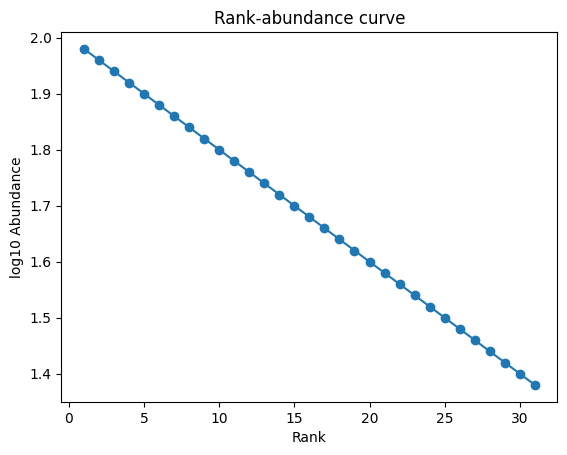

In [11]:
import matplotlib.pyplot as plt

# Create vector of ranks
ranks = list(range(1, 32))

# Calculate abundances
log_abundances = [-0.02 * float(rank) + 2 for rank in ranks]

# Plot
plt.plot(ranks, log_abundances, marker="o")
plt.xlabel("Rank")
plt.ylabel("log10 Abundance")
plt.title("Rank-abundance curve")
plt.show()

In [9]:
10**1.4

25.118864315095795

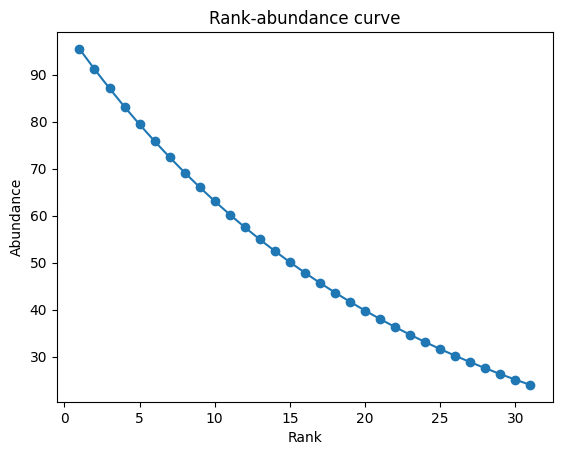

In [12]:
# Create abundances
abundances = [10**log_abundance for log_abundance in log_abundances]

# Plot
plt.plot(ranks, abundances, marker="o")
plt.xlabel("Rank")
plt.ylabel("Abundance")
plt.title("Rank-abundance curve")
plt.show()

[1.71707824 1.46237954 1.80481069 1.50747572 1.51398581 1.60557787
 1.51085901 1.41862453 1.79310641 1.72044232 1.63836085 1.84027337
 1.63011043 1.63172805 2.05354725 1.91201334 1.46721331 1.64638059
 1.71552364 1.96958099 1.46852656 2.02924591 1.8466509  1.57009854
 1.54852454 1.88573308 1.63748764 1.70833414 1.32312192 1.61514786
 1.68166072]


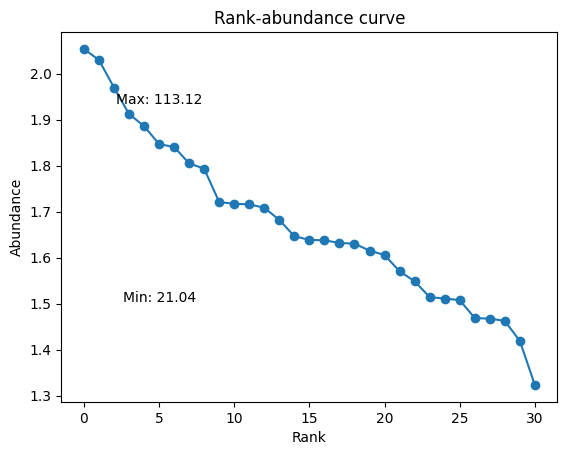

In [25]:
import numpy as np
import matplotlib.pyplot as plt
set_seed = 1236
np.random.seed(set_seed)
# create lognormal distribution
samples = 31
mu = 0.55
sigma = 0.1
s = np.random.lognormal(mu, sigma, samples)
print(s)
# Plot
plt.plot(sorted(s, reverse=True), marker="o")
plt.xlabel("Rank")
plt.ylabel("Abundance")
plt.title("Rank-abundance curve")
# annotate max and min values as abundance
plt.annotate(f"Max: {10**max(s):.2f}", (5, max(s)-0.15), textcoords="offset points", xytext=(0,10), ha='center')
plt.annotate(f"Min: {10**min(s):.2f}", (5, min(s)+0.15), textcoords="offset points", xytext=(0,10), ha='center')
plt.show()

In [29]:
import numpy as np

# Given values
assembly_size = 5 * 10**6  # 5 million bases
desired_coverage = 25  # 25x coverage
mean_read_length = 2050  # Mean read length

# Calculate total bases required
total_bases_required = assembly_size * desired_coverage

# Calculate the estimated number of reads needed
number_of_reads_estimate = total_bases_required / mean_read_length

# Length thresholds
length_thresholds = {
    "200": 172835,
    "500": 152237,
    "1000": 125736,
    "2000": 91035,
    "5000": 42260,
    "10000": 15381,
    "30000": 249,
    "50000": 7,
    "100000": 0,
    "1000000": 0
}

# Create a pool of reads based on length thresholds
read_lengths = []
for length, count in length_thresholds.items():
    read_lengths.extend([int(length)] * count)

# Randomly sample from read lengths until the sum of the sampled reads is approximately 125 million bases
np.random.seed(1236)
current_sum = 0
sampled_reads = []

while current_sum < total_bases_required:
    # Sample in batches to speed up the process
    batch_size = 1000
    sampled_batch = np.random.choice(read_lengths, batch_size)
    batch_sum = sampled_batch.sum()
    
    sampled_reads.extend(sampled_batch)
    current_sum += batch_sum

# Adjust the sampled reads to match the exact required bases
if current_sum > total_bases_required:
    excess = current_sum - total_bases_required
    for i in range(len(sampled_reads) - 1, -1, -1):
        if sampled_reads[i] <= excess:
            excess -= sampled_reads.pop(i)
        if excess <= 0:
            break

# Calculate the total number of sampled reads and the sum of their lengths
number_of_sampled_reads = len(sampled_reads)
sum_sampled_read_lengths = sum(sampled_reads)

# Calculate the mean read length from the sampled reads
sampled_read_lengths = np.array(sampled_reads)
mean_sampled_read_length = sampled_read_lengths.mean()

result = {
    "total_bases_required": total_bases_required,
    "estimated_number_of_reads": number_of_reads_estimate,
    "number_of_sampled_reads": number_of_sampled_reads,
    "sum_sampled_read_lengths": sum_sampled_read_lengths,
    "mean_sampled_read_length": mean_sampled_read_length
}

print(result)


{'total_bases_required': 125000000, 'estimated_number_of_reads': 60975.60975609756, 'number_of_sampled_reads': 94907, 'sum_sampled_read_lengths': 125000000, 'mean_sampled_read_length': 1317.0788245334907}


In [34]:
import numpy as np
import pandas as pd
# Given values
assembly_size = 5 * 10**6  # 5 million bases
desired_coverage = 5

lengths = pd.read_csv("../../data/validation_datasets/qc/CVM74_Cellulophaga_lytica_qc_min_l_200_min_q_10.txt", header=None)[0].values
# create array with 1:len(lengths)
length_idx = np.arange(len(lengths))
# Shuffle the array
# np.random.seed(1236)
np.random.shuffle(length_idx)


total_bp = assembly_size * desired_coverage
assert total_bp < sum(lengths), "Not enough reads to cover genome"

num_reads = 0
length_sum = 0
while length_sum < total_bp:
    length_sum += lengths[length_idx[num_reads]]
    num_reads += 1

print(num_reads, length_sum)
    
    

    



4818 25009402


In [2]:
import json
import os
import glob
import yaml
import pandas as pd
from Bio import SeqIO

with open(f"samples2.yaml") as f:
    samples = yaml.safe_load(f)

qc_files = glob.glob("../../data/validation_datasets/nanoq/*_qc_min_l_200_min_q_10.json")


# get id by removing the path and extension
qc_ids = [os.path.splitext(os.path.basename(f))[0] for f in qc_files]
qc_ids = [f.replace("_qc_min_l_200_min_q_10", "") for f in qc_ids]


df = pd.DataFrame()

for i in qc_ids:
    with open(f"../../data/validation_datasets/nanoq/{i}_qc_min_l_200_min_q_10.json") as f:
        data = json.load(f)
        
    # Read the assembly
    # Correct for e_coli_k12 <- e_coli_K12
    # if i == "e_coli_K12":
    #     i = "e_coli_k12"
    
    assembly = SeqIO.parse(os.path.join(samples[i]["assembly"]), "fasta")
    # calculate length of assembly
    assembly_length = 0
    for record in assembly:
        assembly_length += len(record.seq)
    
    df_tmp = pd.DataFrame(
        {
            "id": i,
            "total_bp": data["bases"],
            "num_reads": data["reads"],
            "assembly_length": assembly_length,
        }, index=[0]
    )
    df = pd.concat([df, df_tmp], ignore_index=True)


In [5]:
dfs = df.sort_values("total_bp", ascending=False, ignore_index=True)
dfs["rank"] = dfs.index + 1
dfs["log_abundance_sampling"] = sorted(s, reverse=True)
dfs["desired_coverage"] = 10**dfs["log_abundance_sampling"]
dfs["num_bases_required"] = dfs["assembly_length"] * dfs["desired_coverage"]
dfs["enough_bases"] = dfs["num_bases_required"] < dfs["total_bp"]



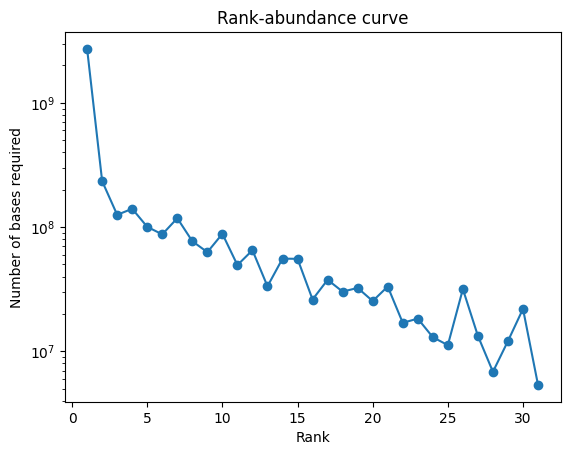

In [6]:
plt.plot(dfs["rank"], dfs["num_bases_required"], marker="o")
plt.xlabel("Rank")
plt.ylabel("Number of bases required")
plt.title("Rank-abundance curve")
plt.yscale("log")
plt.show()

In [7]:
dfs

,id,total_bp,num_reads,assembly_length,rank,log_abundance_sampling,desired_coverage,num_bases_required,enough_bases
0,ZymoHMW,3246576018,455509,29106442,1,1.970475,93.427566,2.719344e+09,True
1,m_ruber,2233295893,217984,3097433,2,1.878845,75.656209,2.343400e+08,True
2,CVM73_Kangiella_aquimarina,2026484702,537220,2700093,3,1.667430,46.497504,1.255476e+08,True
3,e_coli_k12,1999544249,177484,4640158,4,1.480866,30.259809,1.404103e+08,True
4,p_thermoglucosidasius,1158822849,104216,3987264,5,1.401113,25.183294,1.004124e+08,True
5,CVM23_Alkalihalobacillus_clausii,892536838,170043,4498223,6,1.288521,19.432136,8.741008e+07,True
6,CVM38_Duganella_zoogloeoides,885274213,171865,6321951,7,1.270813,18.655744,1.179407e+08,True
7,CVM07_Shewanella_oneidensis,664054750,172715,5135111,8,1.175652,14.984834,7.694878e+07,True
8,CVM77_Acidiphilium_acidophilum,601390413,121252,4495057,9,1.145451,13.978181,6.283272e+07,True
9,CVM68_Rhodococcus_opacus,592935342,253627,9444597,10,0.970762,9.348924,8.829682e+07,True


In [8]:
# Add the number of reads required
for i in dfs["id"]:
       
    lengths = pd.read_csv(f"../../data/validation_datasets/qc/{i}_qc_min_l_200_min_q_10.txt", header=None)[0].values
    # create array with 1:len(lengths)
    length_idx = np.arange(len(lengths))
    # Shuffle the array
    np.random.seed(1236)
    np.random.shuffle(length_idx)

    total_bp = dfs.loc[dfs["id"] == i, "num_bases_required"].values[0]
    num_reads = 0
    length_sum = 0
    while length_sum < total_bp:
        length_sum += lengths[length_idx[num_reads]]
        num_reads += 1

    dfs.loc[dfs["id"] == i, "num_reads_required"] = num_reads
    dfs.loc[dfs["id"] == i, "sampled_length_sum"] = length_sum

In [9]:
dfs.to_csv("rank_abundance.csv", index=False)